In [12]:
interval_str =\
'''
708.06 
1037.76 
1114.81 
96.26 
862.84 
1131.13 
1081.99 
1295.76 
1847.96 
98.35 
1388.14
'''

interval_rep_str =\
'''
2
2
2
1
6
4
4
1
1
1
1
'''

In [13]:
intervals = [float(s.strip()) for s in interval_str.split('\n') if s.strip() != '']
interval_rep = [int(s.strip()) for s in interval_rep_str.split('\n') if s.strip() != '']

[708.06, 708.06, 1037.76, 1037.76, 1114.81, 1114.81, 96.26, 862.84, 862.84, 862.84, 862.84, 862.84, 862.84, 1131.13, 1131.13, 1131.13, 1131.13, 1081.99, 1081.99, 1081.99, 1081.99, 1295.76, 1847.96, 98.35, 1388.14]


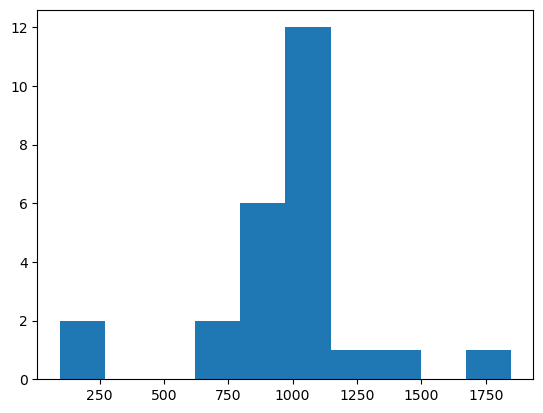

In [16]:
from matplotlib import pyplot as plt
import numpy as np

intervals_expand = []
for i in range(len(intervals)):
    for j in range(interval_rep[i]):
        intervals_expand.append(intervals[i])

print(intervals_expand)
plt.hist(intervals_expand, bins=10)
plt.show()

In [142]:
# Tetra's data @ Aug-07

# read tetra_psleep_data.csv

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# read csv
# df = pd.read_csv('tetra_psleep_data.csv', header = None)
df = pd.read_csv('tetra_psleep_aug8.csv', header = None)

time = pd.to_numeric(df[1][3:]).replace(np.nan, 0).values

berries_per_help = [2, 2, 3, 2, 2]
pokemon_help_intervals = []
pokemon_help_times = []
pokemon_base_freq = np.array([0, 0, 0, 0, 0], dtype = float)

for pkmn in range(5):

    curr_pokemon_help_intervals = []
    curr_pokemon_help_times = []

    base_freq = df[2 + pkmn * 3][2]
    berries = pd.to_numeric(df[2 + pkmn * 3][4:]).replace(np.nan, 0).values
    ingredients = pd.to_numeric(df[3 + pkmn * 3][4:]).replace(np.nan, 0).values
    num_helps = berries / berries_per_help[pkmn] + ingredients

    for i in range(len(num_helps)):
        if num_helps[i] > 0:

            # Find previous help
            prev_help = -1
            for j in range(i - 1, 0, -1):
                if num_helps[j] > 0:
                    prev_help = j
                    break

            if prev_help == -1:
                continue

            # Find time interval
            time_interval = (time[i] - time[prev_help]) / num_helps[i]

            for j in range(int(num_helps[i])):
                curr_pokemon_help_times.append(time[prev_help] + time_interval * (j + 1))
                curr_pokemon_help_intervals.append(time_interval)

    pokemon_help_intervals.append(np.array(curr_pokemon_help_intervals))
    pokemon_help_times.append(np.array(curr_pokemon_help_times))
    pokemon_base_freq[pkmn] = base_freq

In [143]:
use_normalized = True

if use_normalized:

    p_interval = []
    for pokemon_id in range(5):
        help_intervals = pokemon_help_intervals[pokemon_id] / pokemon_base_freq[pokemon_id]
        p_interval.append(help_intervals)

    p_interval = np.concatenate(p_interval)
    p_time = np.concatenate(pokemon_help_times)
    baseline = 1.0

else:

    pokemon_id = 0 # eepachu
    p_interval = pokemon_help_intervals[pokemon_id]
    p_time = pokemon_help_times[pokemon_id]
    baseline = pokemon_base_freq[pokemon_id]

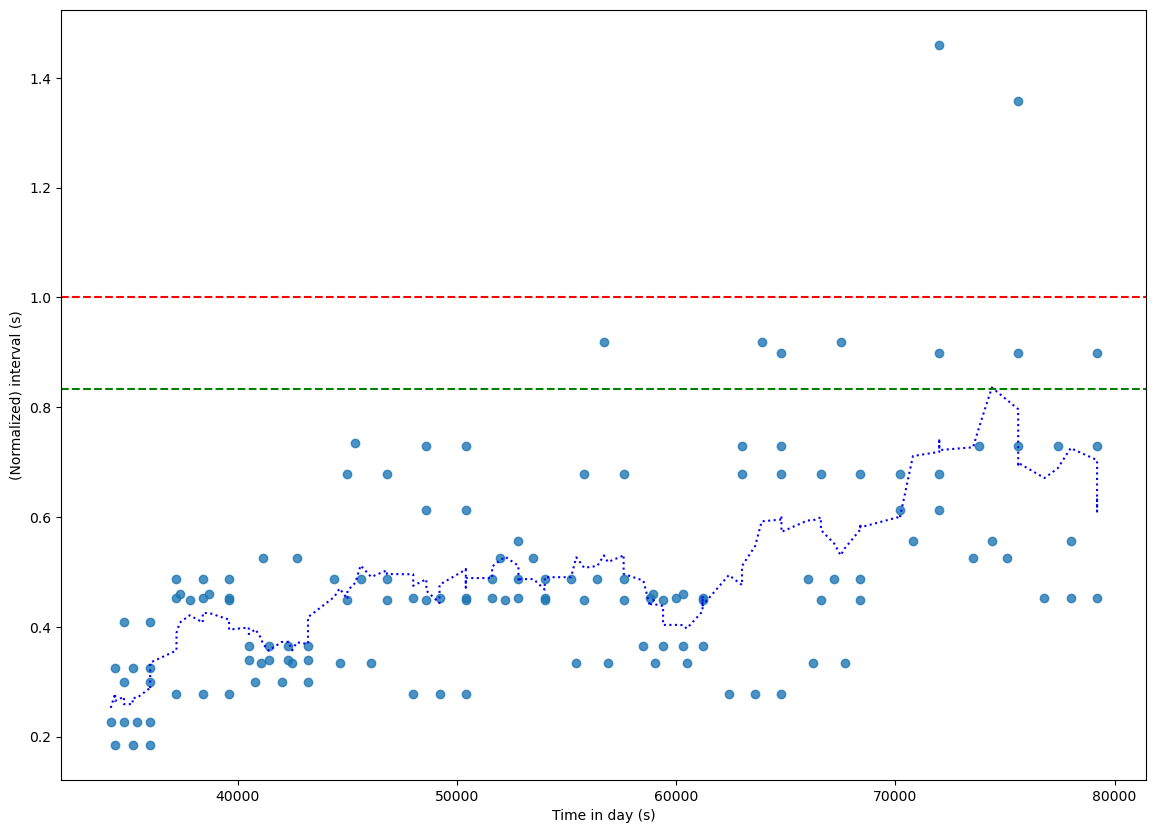

In [144]:
# Variables: p_time, p_interval, baseline

# Sort accroading to p_time
p_time, p_interval = zip(*sorted(zip(p_time, p_interval)))

p_interval_ema = np.zeros(len(p_interval))

# Compute an exponential moving average on p_interval -> p_interval_ema array
# alpha = 0.15
# p_interval_ema[0] = p_interval[0]
# for i in range(1, len(p_interval)):
#     p_interval_ema[i] = p_interval_ema[i - 1] * (1 - alpha) + p_interval[i] * alpha

# Compute average by a centered time window
w = 5
for i in range(0, len(p_interval)):
    s = max(0, i - w)
    e = i + w
    p_interval_ema[i] = np.mean(p_interval[s:e])

# Plot
plt.figure(figsize=(14, 10))
plt.plot(p_time, p_interval, 'o', alpha = 0.8)
plt.plot(p_time, p_interval_ema, color = "blue", linestyle=':')

# Plot an horizontal baseline
plt.axhline(y=baseline, color='r', linestyle='--')
plt.axhline(y=baseline / 1.2, color='g', linestyle='--')

plt.xlabel('Time in day (s)')
plt.ylabel('(Normalized) interval (s)')

plt.show()

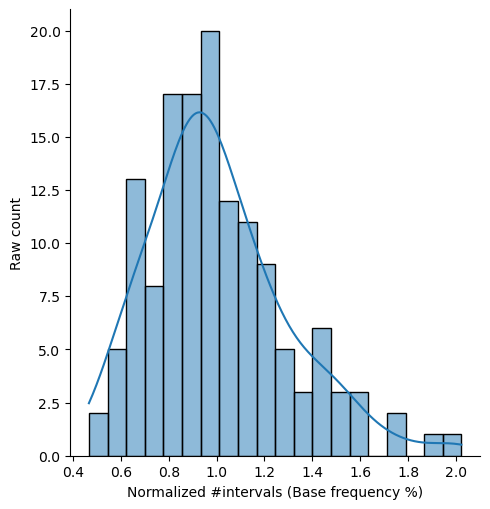

In [145]:
# Histrogram of intervals
import seaborn as sns
sns.displot(p_interval / p_interval_ema, kde=True, rug=False, bins=20)
plt.xlabel('Normalized #intervals (Base frequency %)')
plt.ylabel('Raw count')
plt.show()